In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishing-site-urls/phishing_site_urls.csv
/kaggle/input/masks/user.png
/kaggle/input/masks/upvote.png
/kaggle/input/masks/star.png
/kaggle/input/masks/comment.png
/kaggle/input/masks/loc.png
/kaggle/input/masks/masks-wordclouds/user.png
/kaggle/input/masks/masks-wordclouds/upvote.png
/kaggle/input/masks/masks-wordclouds/star.png
/kaggle/input/masks/masks-wordclouds/comment.png
/kaggle/input/masks/masks-wordclouds/loc.png


## Read My Article on Medium [here](https://medium.com/@taruntiwari.hp/phishing-sites-predictor-using-fastapi-2b5de0272f0)
## Watch My Explaination Video on YouTube [here](https://youtu.be/zKNXHluHneU)

### * **What is a phishing attack?**
* Phishing is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. It occurs when an attacker, masquerading as a trusted entity, dupes a victim into opening an email, instant message, or text message. 

### * Phishing attack examples
* A spoofed email ostensibly from myuniversity.edu is mass-distributed to as many faculty members as possible. The email claims that the user’s password is about to expire. Instructions are given to go to myuniversity.edu/renewal to renew their password within 24 hours.>
<img src='https://github.com/taruntiwarihp/raw_images/blob/master/phishing-attack-email-example.png?raw=true'>

* Several things can occur by clicking the link. For example:

    1. The user is redirected to myuniversity.edurenewal.com, a bogus page appearing exactly like the real renewal page, where both new and existing passwords are requested. The attacker, monitoring the page, hijacks the original password to gain access to secured areas on the university network.
    
    2. The user is sent to the actual password renewal page. However, while being redirected, a malicious script activates in the background to hijack the user’s session cookie. This results in a reflected XSS attack, giving the perpetrator privileged access to the university network.

##### * Importing some useful libraries

In [2]:
!pip install selenium

     |████████████████████████████████| 904 kB 897 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics 
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline 
# It sets the backend of matplotlib to the 'inline' backend:
import plotly.express as px
import time # calculate time 

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

In [4]:
# Loading the dataset
phish_data = pd.read_csv('phishing_site_urls.csv')

In [5]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [6]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [7]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


* **About dataset**
* Data is containg 5,49,346 unique entries.
* There are two columns.
* Label column is prediction col which has 2 categories 
    A. Good - which means the urls is not containing malicious stuff and **this site is not a Phishing Site.**
    B. Bad - which means the urls contains malicious stuffs and **this site isa Phishing Site.**
* There is no missing value in the dataset.

In [8]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [9]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

In [10]:
#visualizing target_col
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

### Preprocessing
* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [11]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')#to getting alpha only

In [12]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [13]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [14]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.6869161400001076 sec


In [15]:
phish_data.sample(5)

,URL,Label,text_tokenized
353581,hollywoodteenmovies.com/ForSaleSamsonBurke.html,good,"[hollywoodteenmovies, com, ForSaleSamsonBurke,..."
125117,tvrey.mx/tejeda/templates/base/element/index.htm,bad,"[tvrey, mx, tejeda, templates, base, element, ..."
432981,soccerhotnews.com/rank.php?player_type=&alpha=B,good,"[soccerhotnews, com, rank, php, player, type, ..."
318381,ebay.com/itm/Gametime-Montreal-Canadiens-2010-...,good,"[ebay, com, itm, Gametime, Montreal, Canadiens..."
91066,www.gamecabinet.com/reviews/Pirateer.html,good,"[www, gamecabinet, com, reviews, Pirateer, html]"


#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [16]:
stemmer = SnowballStemmer("english") # choose a language

In [17]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 54.13507289300003 sec


In [18]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
108023,server.security.hotelneelgiri.com/access/MGen/...,bad,"[server, security, hotelneelgiri, com, access,...","[server, secur, hotelneelgiri, com, access, mg..."
231105,poussierevirtuelle.over-blog.com/60-categorie-...,good,"[poussierevirtuelle, over, blog, com, categori...","[poussierevirtuell, over, blog, com, categori,..."
130626,backwoodsvapeva.com/czx/Ed/,bad,"[backwoodsvapeva, com, czx, Ed]","[backwoodsvapeva, com, czx, ed]"
184018,epguides.com/GhostLab/,good,"[epguides, com, GhostLab]","[epguid, com, ghostlab]"
180114,en.wikipedia.org/wiki/Ron_Theobald,good,"[en, wikipedia, org, wiki, Ron, Theobald]","[en, wikipedia, org, wiki, ron, theobald]"


In [19]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.27809664799997336 sec


In [20]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
402381,nbcuotlp.com/,good,"[nbcuotlp, com]","[nbcuotlp, com]",nbcuotlp com
30984,www.yuqinge.com/flash/?us.battle.net/login/en/...,bad,"[www, yuqinge, com, flash, us, battle, net, lo...","[www, yuqing, com, flash, us, battl, net, logi...",www yuqing com flash us battl net login en ref...
455130,uml.edu/centers/CFWC/Staff/Donnelly.html,good,"[uml, edu, centers, CFWC, Staff, Donnelly, html]","[uml, edu, center, cfwc, staff, donnelli, html]",uml edu center cfwc staff donnelli html
226827,people.famouswhy.com/richard_pryor/,good,"[people, famouswhy, com, richard, pryor]","[peopl, famouswhi, com, richard, pryor]",peopl famouswhi com richard pryor
503926,bigwerks.bigwerks.com/zxap2wls,bad,"[bigwerks, bigwerks, com, zxap, wls]","[bigwerk, bigwerk, com, zxap, wls]",bigwerk bigwerk com zxap wls


### Visualization 
**1. Visualize some important keys using word cloud**

In [21]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [22]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [23]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


* create a function to visualize the important keys from url 

In [24]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [25]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

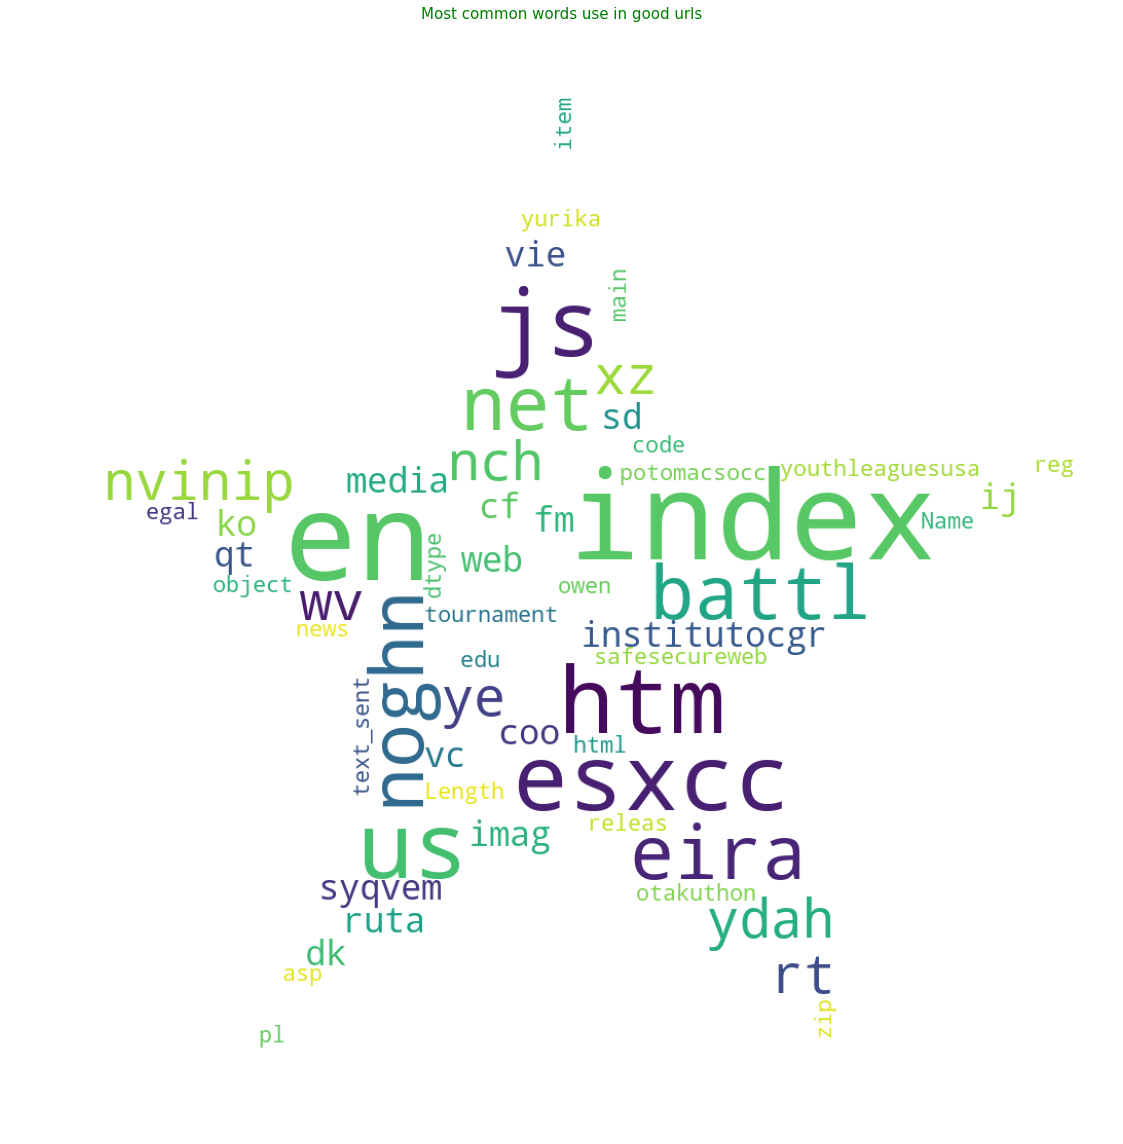

In [26]:
common_text = str(data)
common_mask = np.array(Image.open(d+'star.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, 
               title = 'Most common words use in good urls', title_size=15)

In [27]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

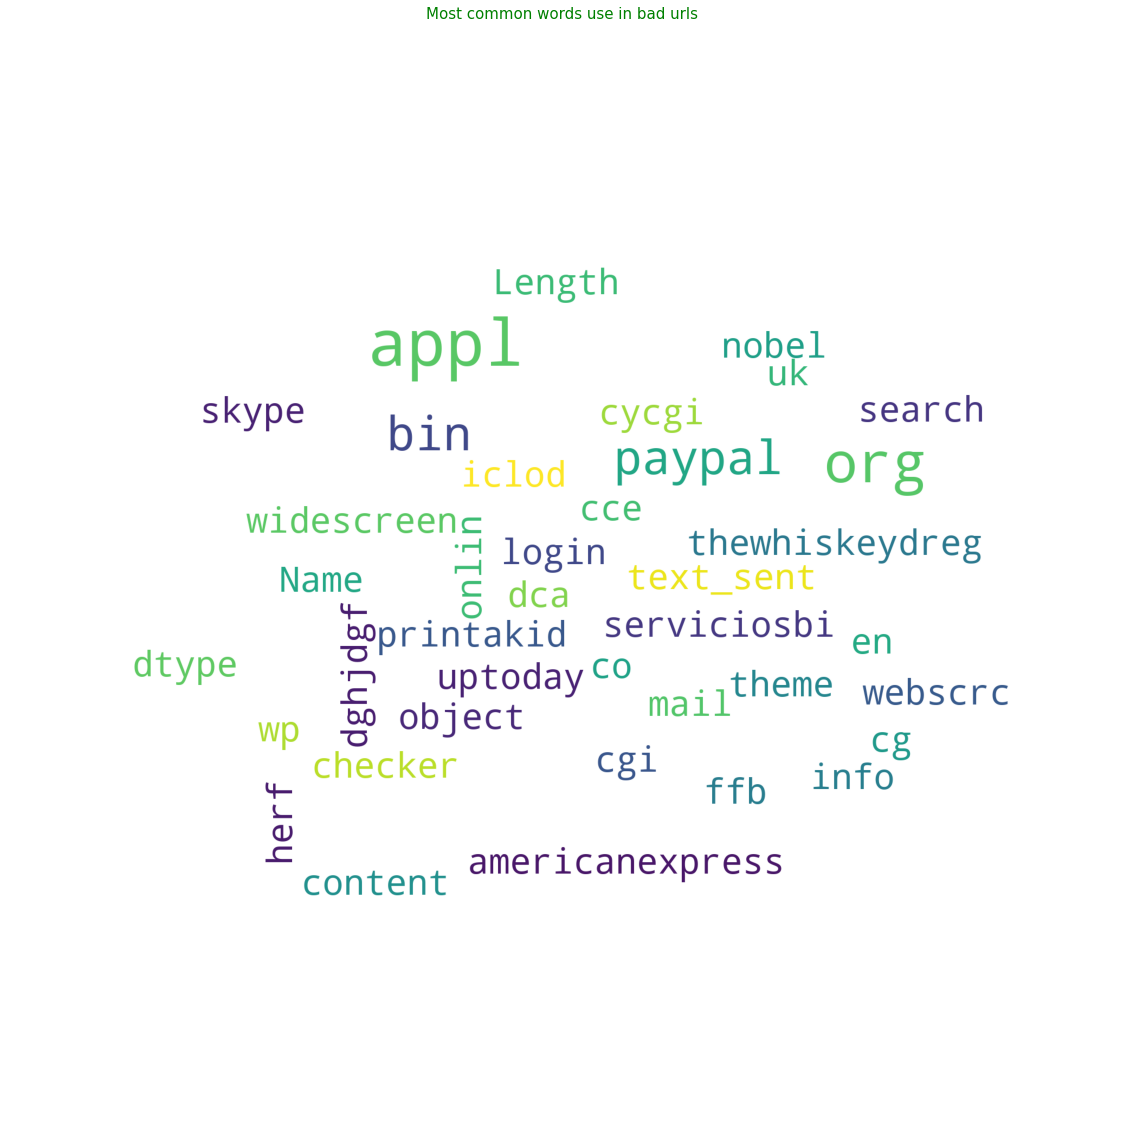

In [28]:
common_text = str(data)
common_mask = np.array(Image.open(d+'comment.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, 
               title = 'Most common words use in bad urls', title_size=15)

2. Visualize internal links, it will shows all redirect links.
    * P> NetworkX visual links nodes are not working on kaggle, but you can see it on my Jupyter notebook <a href='https://github.com/taruntiwarihp/Projects_DS/tree/master/Phishing%20Site%20URLs%20Prediction'>here</a>

### Creating Model
#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [29]:
#create cv object
cv = CountVectorizer()

In [30]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  -----

In [31]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [32]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### * Spliting the data 

In [33]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [34]:
# create lr object
lr = LogisticRegression()

In [35]:
lr.fit(trainX,trainY)

LogisticRegression()

In [36]:
lr.score(testX,testY)

0.9628650691365036

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [37]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9774349589450716
Testing Accuracy : 0.9628650691365036

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.90      0.97      0.93     36715
        Good       0.99      0.96      0.97    100622

    accuracy                           0.96    137337
   macro avg       0.94      0.96      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


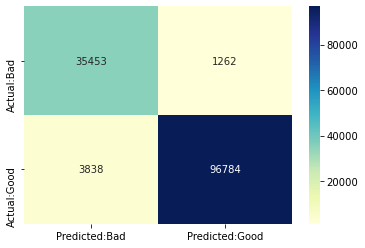

In [38]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [39]:
# create mnb object
mnb = MultinomialNB()

In [40]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [41]:
mnb.score(testX,testY)

0.956748727582516

*** MultinomialNB gives us 95% accuracy**  

In [42]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9741874570701126
Testing Accuracy : 0.956748727582516

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.93      0.92     38345
        Good       0.97      0.97      0.97     98992

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


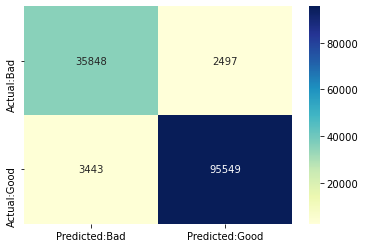

In [43]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

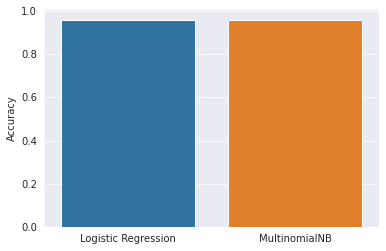

In [44]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [45]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+)  -- these tolenizers giving me low accuray 

In [46]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [47]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('logisticregression', LogisticRegression())])

In [48]:
pipeline_ls.score(testX,testY) 

0.9655882973998267

Training Accuracy : 0.9807261491860615
Testing Accuracy : 0.9655882973998267

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36818
        Good       0.99      0.97      0.98    100519

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


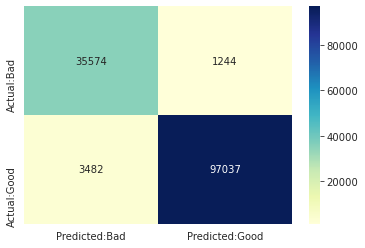

In [49]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [50]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [51]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9655882973998267


***That’s it. See, it's that simple yet so effective. We get an accuracy of 98%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

* Bad links => this are phishing sites
yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php
fazan-pacir.rs/temp/libraries/ipad
www.tubemoviez.exe
svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

* Good links => this are not phishing sites
www.youtube.com/
youtube.com/watch?v=qI0TQJI3vdU
www.retailhellunderground.com/
restorevisioncenters.com/html/technology.html

In [52]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']


### Protections
#### How to Protect Your Computer 
Below are some key steps to protecting your computer from intrusion:

1. **Keep Your Firewall Turned On:** A firewall helps protect your computer from hackers who might try to gain access to crash it, delete information, or even steal passwords or other sensitive information. Software firewalls are widely recommended for single computers. The software is prepackaged on some operating systems or can be purchased for individual computers. For multiple networked computers, hardware routers typically provide firewall protection.

2. **Install or Update Your Antivirus Software:** Antivirus software is designed to prevent malicious software programs from embedding on your computer. If it detects malicious code, like a virus or a worm, it works to disarm or remove it. Viruses can infect computers without users’ knowledge. Most types of antivirus software can be set up to update automatically.

3. **Install or Update Your Antispyware Technology:** Spyware is just what it sounds like—software that is surreptitiously installed on your computer to let others peer into your activities on the computer. Some spyware collects information about you without your consent or produces unwanted pop-up ads on your web browser. Some operating systems offer free spyware protection, and inexpensive software is readily available for download on the Internet or at your local computer store. Be wary of ads on the Internet offering downloadable antispyware—in some cases these products may be fake and may actually contain spyware or other malicious code. It’s like buying groceries—shop where you trust.

4. **Keep Your Operating System Up to Date:** Computer operating systems are periodically updated to stay in tune with technology requirements and to fix security holes. Be sure to install the updates to ensure your computer has the latest protection.

5. **Be Careful What You Download:** Carelessly downloading e-mail attachments can circumvent even the most vigilant anti-virus software. Never open an e-mail attachment from someone you don’t know, and be wary of forwarded attachments from people you do know. They may have unwittingly advanced malicious code.

6. **Turn Off Your Computer:** With the growth of high-speed Internet connections, many opt to leave their computers on and ready for action. The downside is that being “always on” renders computers more susceptible. Beyond firewall protection, which is designed to fend off unwanted attacks, turning the computer off effectively severs an attacker’s connection—be it spyware or a botnet that employs your computer’s resources to reach out to other unwitting users.

## To see How model deploy using fastapi visit my github <a href='https://github.com/taruntiwarihp/Projects_DS/tree/master/Phishing%20Site%20URLs%20Prediction'>here</a>
* Thank you